In [ ]:

# Assignment #2  - Experiments with recurrent networks
# Updated March 31
# Due date: April 5th, noon

# Recurrent Neural Networks suffer from short-term memory
# A different, more complex network can help to bring the deeper past into the present
# Enter the Long Short-Term Memory model
# https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
# https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay

# Application: complete a jword game
# Training data: clean jokes collected form Reddit
# https://closeheat.com/blog/pytorch-lstm-text-generation-tutorial

# Addendum: saving and loading a model:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

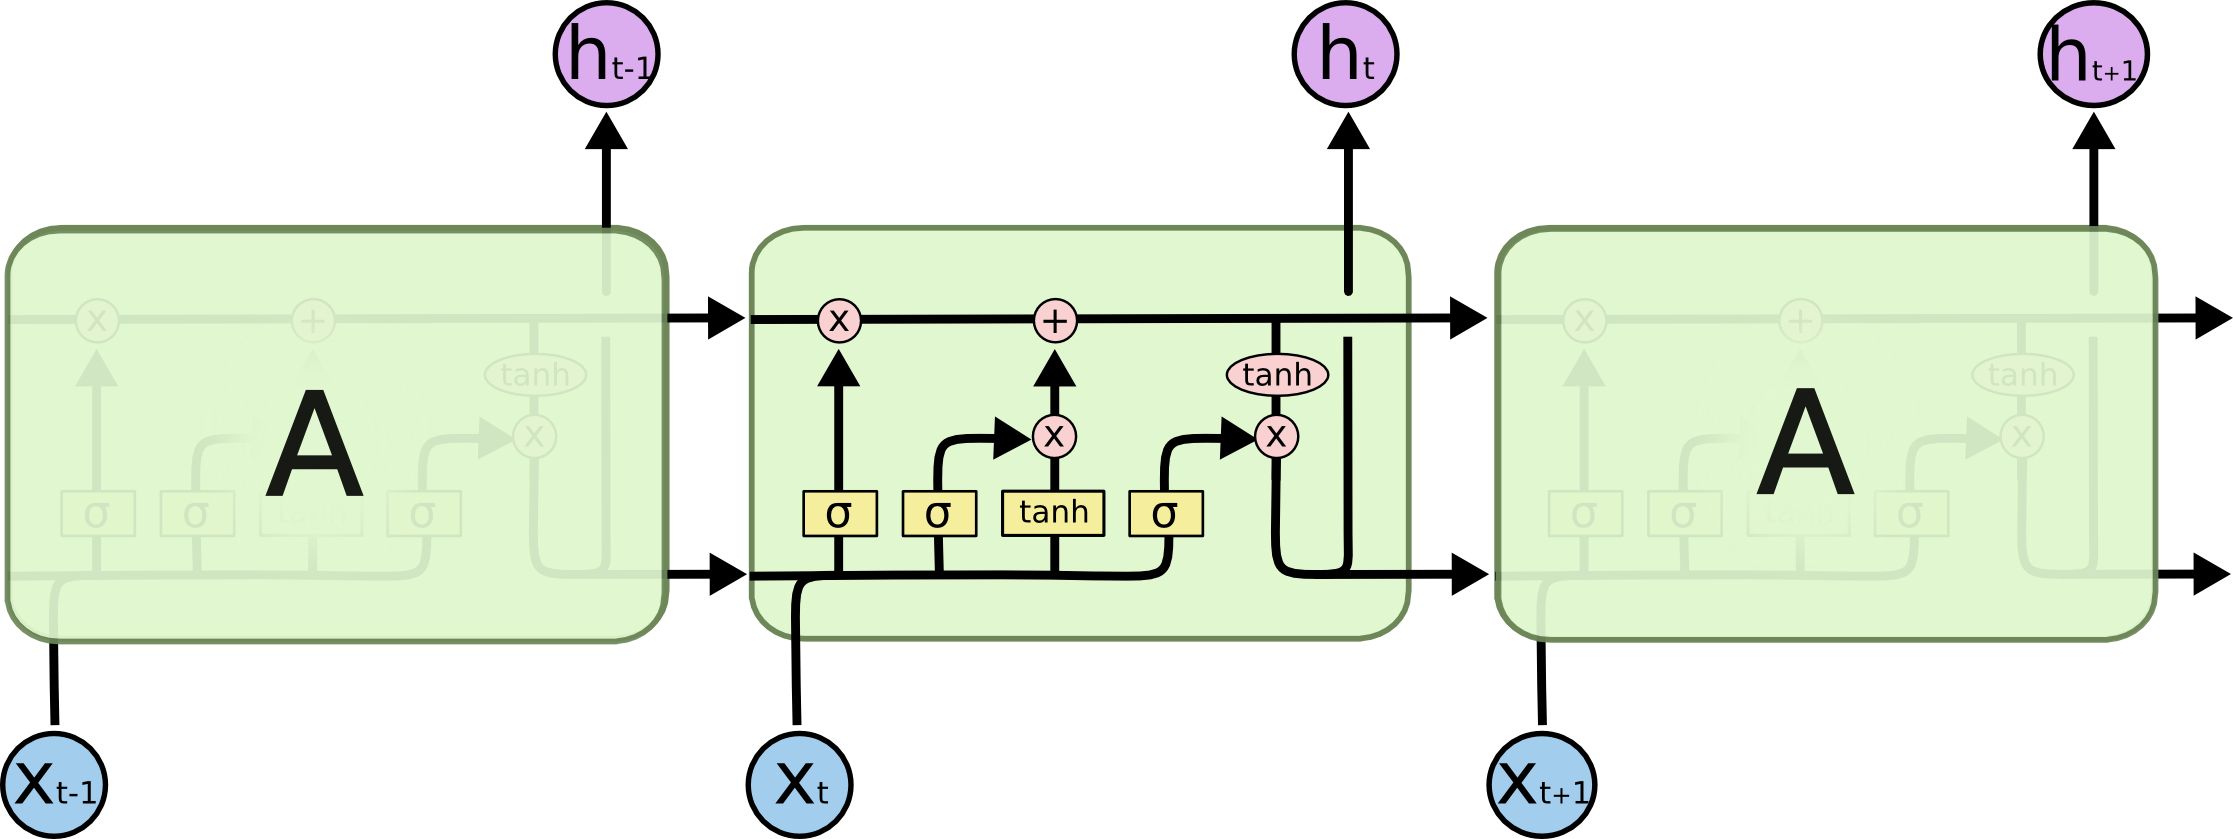


In [ ]:
import os, sys
import numpy
import torch
import pandas
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#change this based on your setup
root = '/content/drive/My Drive/Colab/ML/'
sys.path.append(root +'code/')
datapath =  root + 'data/'

Mounted at /content/drive


In [ ]:
# Check the datset wtih 122 entries
source = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes_123.txt'
jokes = pandas.read_csv(source, sep='\t')
print(len(jokes))
jokes.head(3)


122


,ID,Joke
0,1,What's the difference between a fish and a gui...
1,2,What do you call two crows? Attempted murder.
2,3,What do you call a t-shirt with stalks of whea...


In [ ]:
# Check the dataset with 1499 entries
source = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes_1500.txt'
jokes = pandas.read_csv(source, sep='\t')
print(len(jokes))
jokes.head(3)


1499


,ID,Joke
0,1,What did the bartender say to the jumper cable...
1,2,Don't you hate jokes about German sausage? The...
2,3,Two artists had an art contest... It ended in ...


In [ ]:
# Check the dataset with all  entries
source = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes.txt'
jokes = pandas.read_csv(source, sep='\t')
print(len(jokes))
jokes.head(3)

1622


,ID,Joke
0,1,What did the bartender say to the jumper cable...
1,2,Don't you hate jokes about German sausage? The...
2,3,Two artists had an art contest... It ended in ...


In [ ]:
#dataset class to make things easier

class Dataset(torch.utils.data.Dataset):
    def __init__(self,args,):
        self.args = args
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        #self.train_test = self.create_test_train_data()
        
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pandas.read_csv(self.args.source, sep='\t')
        #train_df = pandas.read_csv(self.args.source)
        stext = train_df['Joke'].str.cat(sep=' ')
        text = stext.split(' ')
        return (text)

    #def create_test_train_data(self):
    #    train_text, test_text = train_test_split(range(len(self.words)), test_size=0.1, shuffle=True)
    #    return (train_text, test_text)

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return (sorted(word_counts, key=word_counts.get, reverse=True))

    def __len__(self):
        return (len(self.words_indexes) - self.args.sequence_length)

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.args.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.args.sequence_length+1]),
        )

In [ ]:
# LSTM class

class RNN_LSTM(nn.Module):
    def __init__(self, dataset):
        super(RNN_LSTM, self).__init__()
        self.lstm_size = 128                                   #Experiment: increase to 512?
        self.embedding_dim = 128
        self.num_layers = 3                                    #Experiment: add more layers?

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,                                       #Experiment: increase? reduce?
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [ ]:
# define the training function

def train(dataset, model, args):
    model.train()
    dataloader = DataLoader(dataset, batch_size=args.batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)             #Experiment: increase?

    for epoch in range(args.max_epochs):
        state_h, state_c = model.init_state(args.sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [ ]:
#define the prediction step

def predict(dataset, model, text, next_words):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = numpy.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return (words)

In [ ]:
# Define parameters, dataset and model
# These are parameters you can and should experiment with
# Here we are using the full dataset
datasource = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes.txt'
class Args:
  max_epochs = 2  #(start with 5)
  batch_size = 256
  sequence_length = 4
  source = datasource

args=Args()

dataset = Dataset(args)
model = RNN_LSTM(dataset)

In [ ]:
#Train the model on the data
train(dataset, model, args)

In [ ]:
#Save the trained model, so you can use it elsewhere (check your datapath to confirm)
modelpath = datapath + '/jokemodel.pt'
torch.save(model.state_dict(), modelpath)

In [ ]:
#What is inside of the model anyway?
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embedding.weight 	 torch.Size([6925, 128])
lstm.weight_ih_l0 	 torch.Size([512, 128])
lstm.weight_hh_l0 	 torch.Size([512, 128])
lstm.bias_ih_l0 	 torch.Size([512])
lstm.bias_hh_l0 	 torch.Size([512])
lstm.weight_ih_l1 	 torch.Size([512, 128])
lstm.weight_hh_l1 	 torch.Size([512, 128])
lstm.bias_ih_l1 	 torch.Size([512])
lstm.bias_hh_l1 	 torch.Size([512])
lstm.weight_ih_l2 	 torch.Size([512, 128])
lstm.weight_hh_l2 	 torch.Size([512, 128])
lstm.bias_ih_l2 	 torch.Size([512])
lstm.bias_hh_l2 	 torch.Size([512])
fc.weight 	 torch.Size([6925, 128])
fc.bias 	 torch.Size([6925])


In [ ]:
# And on another system, you can load that model again and use it
datasource = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes.txt'
class Args:
  max_epochs = 2  #(start with 5)
  batch_size = 256
  sequence_length = 4
  source = datasource

args=Args()

dataset = Dataset(args)
model = RNN_LSTM(dataset)
model.load_state_dict(torch.load(modelpath))


<All keys matched successfully>

In [ ]:
#Once the model is loaded, you can run the inference (prediction)
starter = 'Knock knock. Who''s there?'
next_words = 1
print(predict(dataset, model, starter, next_words))

['Knock', 'knock.', 'Whos', 'there?', 'Thai']


#Your assignment below ...



1) Run the predictor multiple times. What do you observe ? 
[100 words or more]

2)  Instead of using all data for training, use one of the smaller datasets (cleanjokes_1500 or cleanjokes_123)

Implement this change in a code cell. Train the model and run the predictor. 

What do you observe?


In [ ]:
#Build a model with the datasete 123 or 1500. What do you observe?
datasource = 'https://raw.githubusercontent.com/realtechsupport/CriticalMachineLearning/main/various_datasets/reddit_cleanjokes_123.txt'
class Args:
  max_epochs = 2                  #(start with 5)
  batch_size = 256
  sequence_length = 4
  source = datasource

args=Args()

dataset = Dataset(args)
model_123 = RNN_LSTM(dataset)
train(dataset, model_123, args)

{'epoch': 0, 'batch': 0, 'loss': 6.768951892852783}
{'epoch': 0, 'batch': 1, 'loss': 6.764188766479492}
{'epoch': 0, 'batch': 2, 'loss': 6.760172367095947}
{'epoch': 0, 'batch': 3, 'loss': 6.755599021911621}
{'epoch': 0, 'batch': 4, 'loss': 6.754730701446533}
{'epoch': 0, 'batch': 5, 'loss': 6.747175693511963}
{'epoch': 0, 'batch': 6, 'loss': 6.747121334075928}
{'epoch': 1, 'batch': 0, 'loss': 6.699312210083008}
{'epoch': 1, 'batch': 1, 'loss': 6.694838047027588}
{'epoch': 1, 'batch': 2, 'loss': 6.661100387573242}
{'epoch': 1, 'batch': 3, 'loss': 6.656975746154785}
{'epoch': 1, 'batch': 4, 'loss': 6.5810041427612305}
{'epoch': 1, 'batch': 5, 'loss': 6.498974323272705}
{'epoch': 1, 'batch': 6, 'loss': 6.491902828216553}


In [ ]:
# evaluate on the the model trained with the tiny dataset

starter = 'Knock'
next_words = 1
print(predict(dataset, model_123, starter, next_words))

['Knock', 'why']


3) Change some of the  model parameters in the class RNN_LSTM (num layers, lstm size, etc). Retrain and run some predictions - what happens?

In [ ]:
#self.num_layers = 3 
#self.lstm_size = 128 

4) How could you continue the Knock Knock game?
Write a script that implements your solution.

Below is a simple approach to get started. Can you improve on this solution?

Once you are content with your code, create a function with that code and move your work to the VM.

Add a nice interface on the website


In [ ]:
#make sure you use your prefered model here..

import re
pattern = "[^0-9a-zA-Z\s]+"

question1 = 'Knock knock. Who''s there?'
nwords = 1
try:
  round1 = predict(dataset, model, question1, nwords)
  answer1 = (round1[-1])
  answer1 = re.sub(pattern, ' ', answer1)
  print(question1.capitalize())
  print(answer1.capitalize())

  question2 = answer1 + ' who ?'
  nwords = nwords + 1
  round2 = predict(dataset, model, question2, nwords)
  answer2 = round2[-2:]
  print(question2.capitalize())

  response2 = answer2[0] +  ' ' + answer2[1]
  response2 = re.sub(pattern, ' ', response2)
  print(answer1.capitalize(), response2) 
except:
  print('> Something went wrong..Try again')




Knock knock. whos there?
Surrounded
Surrounded who ?
Surrounded Ouch you 


++Add an image of the model working on your VM++

Just show the front end website (mobile phone image is fine).

